In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc,precision_recall_curve,roc_curve,confusion_matrix
import os,sys
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
np.random.seed(10)
random.seed(10)


## His functions used to read the data

In [4]:
def aaindex(peptide,after_pca):

    amino = 'ARNDCQEGHILKMFPSTWYV-'
    matrix = np.transpose(after_pca)   # [12,21]
    encoded = np.empty([len(peptide), 12])  # (seq_len,12)
    for i in range(len(peptide)):
        query = peptide[i]
        if query == 'X': query = '-'
        query = query.upper()
        encoded[i, :] = matrix[:, amino.index(query)]

    return encoded

def rescue_unknown_hla(hla, dic_inventory):
    type_ = hla[4]
    first2 = hla[6:8]
    last2 = hla[8:]
    big_category = dic_inventory[type_]
    if not big_category.get(first2) == None:
        small_category = big_category.get(first2)
        distance = [abs(int(last2) - int(i)) for i in small_category]
        optimal = min(zip(small_category, distance), key=lambda x: x[1])[0]
        return 'HLA-' + str(type_) + '*' + str(first2) + str(optimal)
    else:
        small_category = list(big_category.keys())
        distance = [abs(int(first2) - int(i)) for i in small_category]
        optimal = min(zip(small_category, distance), key=lambda x: x[1])[0]
        return 'HLA-' + str(type_) + '*' + str(optimal) + str(big_category[optimal][0])

def hla_df_to_dic(hla):
    dic = {}
    for i in range(hla.shape[0]):
        col1 = hla['HLA'].iloc[i]  # HLA allele
        col2 = hla['pseudo'].iloc[i]  # pseudo sequence
        dic[col1] = col2
    return dic

def peptide_data_aaindex(peptide,after_pca):   # return numpy array [10,12,1]
    length = len(peptide)
    if length == 10:
        encode = aaindex(peptide,after_pca)
    elif length == 9:
        peptide = peptide[:5] + '-' + peptide[5:]
        encode = aaindex(peptide,after_pca)
    encode = encode.reshape(encode.shape[0], encode.shape[1], -1)
    return encode


def hla_data_aaindex(hla_dic,hla_type,after_pca):    # return numpy array [34,12,1]
    try:
        seq = hla_dic[hla_type]
    except KeyError:
        hla_type = rescue_unknown_hla(hla_type,dic_inventory)
        seq = hla_dic[hla_type]
    encode = aaindex(seq,after_pca)
    encode = encode.reshape(encode.shape[0], encode.shape[1], -1)
    return encode

def dict_inventory(inventory):
    dicA, dicB, dicC = {}, {}, {}
    dic = {'A': dicA, 'B': dicB, 'C': dicC}

    for hla in inventory:
        type_ = hla[4]  # A,B,C
        first2 = hla[6:8]  # 01
        last2 = hla[8:]  # 01
        try:
            dic[type_][first2].append(last2)
        except KeyError:
            dic[type_][first2] = []
            dic[type_][first2].append(last2)

    return dic

def construct_aaindex(ori,hla_dic,after_pca):
    series = []
    for i in range(ori.shape[0]):
        peptide = ori['peptide'].iloc[i]
        hla_type = ori['HLA'].iloc[i]
        immuno = np.array(ori['immunogenicity'].iloc[i]).reshape(1,-1)   # [1,1]

        encode_pep = peptide_data_aaindex(peptide,after_pca)    # [10,12]

        encode_hla = hla_data_aaindex(hla_dic,hla_type,after_pca)   # [46,12]
        series.append((encode_pep, encode_hla, immuno))
    return series

def pull_peptide_aaindex(dataset):
    result = np.empty([len(dataset),10,12,1])
    for i in range(len(dataset)):
        result[i,:,:,:] = dataset[i][0]
    return result

def pull_hla_aaindex(dataset):
    result = np.empty([len(dataset),46,12,1])
    for i in range(len(dataset)):
        result[i,:,:,:] = dataset[i][1]
    return result


def pull_label_aaindex(dataset):
    col = [item[2] for item in dataset]
    result = [0 if item == 'Negative' else 1 for item in col]
    result = np.expand_dims(np.array(result),axis=1)
    return result


## My functions

In [5]:
def load_training_and_validataion_dataset(path_to_partitions,train_splits):
    import random
    training_partions = random.sample(range(10),train_splits)
    # training_partions = [9, 0, 6, 3, 4, 8, 1, 7]
    validation_partions = [i for i in range(10) if i not in training_partions]

    # path_to_partitions = "../data/partitions"
    partitions = []
    for file in os.listdir(path_to_partitions):
        path_to_file = os.path.join(path_to_partitions,file)
        data = pd.read_csv(path_to_file,sep="\t",names=["peptide","label","HLA"])
        partitions.append(data)
    training_df = pd.concat([partitions[i] for i in training_partions])
    validation_df = pd.concat([partitions[i] for i in validation_partions])
    return training_df, validation_df,training_partions,validation_partions

def retrieve_information_from_df(data_split,entire_df):
    potential = []
    immunogenicity = []
    tested = []
    responded = []
    for i,row in data_split.iterrows():
        peptide, HLA = row["peptide"], row['HLA']
        original_entry = entire_df[(entire_df['peptide']==peptide) & (entire_df['HLA'] == HLA)]
        assert len(original_entry) == 1
        potential.append(float(original_entry['potential']))
        immunogenicity.append(original_entry['immunogenicity'].values[0])
        tested.append(int(original_entry['test']))
        responded.append(int(original_entry['respond']))
     
    data_split['potential'] = potential
    data_split['immunogenicity'] = immunogenicity
    data_split['test'] = tested
    data_split['respond'] = responded

    return data_split  

## Loading the data

The strategy used by the paper to load the data (Incorrect because 100% identity between validation and validation data)

In [6]:
# # Loading the dataset
# after_pca = np.loadtxt('../DeepImmuno//reproduce/data/after_pca.txt')
# ori = pd.read_csv('../DeepImmuno//reproduce/data/remove0123_sample100.csv')
# ori = ori.sample(frac=1, replace=False).set_index(pd.Index(np.arange(ori.shape[0])))
# hla = pd.read_csv('../DeepImmuno/reproduce/data/hla2paratopeTable_aligned.txt', sep='\t')
# hla_dic = hla_df_to_dic(hla)
# inventory = list(hla_dic.keys())
# dic_inventory = dict_inventory(inventory)
# dataset = construct_aaindex(ori, hla_dic, after_pca)
# input1 = pull_peptide_aaindex(dataset)
# input2 = pull_hla_aaindex(dataset)
# label = pull_label_aaindex(dataset)

# input1 = input1.astype('float32')
# input2 = input2.astype('float32')
# label = label.astype('float32')

# array = np.arange(len(dataset))
# train_index = np.random.choice(array,int(len(dataset)*0.9),replace=False)
# valid_index = [item for item in array if item not in train_index]

# input1 = input1.astype('float32')
# input2 = input2.astype('float32')
# label = label.astype('float32')

# # Reshaped data
# input1 = pull_peptide_aaindex(dataset).reshape(-1,1,10,12)
# input2 = pull_hla_aaindex(dataset).reshape(-1,1,46,12)
# label = pull_label_aaindex(dataset)


# peptide_train, peptide_val = input1[train_index], input1[valid_index]
# HLA_train, HLA_val = input2[train_index], input2[valid_index]
# label_train, label_val = label[train_index], label[valid_index]


# peptide_train = peptide_train.reshape(-1,1,10,12).astype('float32')
# HLA_train = HLA_train.reshape(-1,1,46,12).astype('float32')
# label_train = label_train.astype('float32')

# peptide_val = peptide_val.reshape(-1,1,10,12).astype('float32')
# HLA_val = HLA_val.reshape(-1,1,46,12).astype('float32')
# label_val = label_val.astype('float32')

Correct partioning of the data (The data is partioned such that the validation and )

In [7]:
# Loading the dataset
after_pca = np.loadtxt('../DeepImmuno/reproduce/data/after_pca.txt')
hla = pd.read_csv('../DeepImmuno/reproduce/data/hla2paratopeTable_aligned.txt', sep='\t')
hla_dic = hla_df_to_dic(hla)
inventory = list(hla_dic.keys())
dic_inventory = dict_inventory(inventory)

entire_df = pd.read_csv('../data/deep_immuno_2.csv')
# Allocating the partitions of the trainign and validation data
training_df, validation_df,training_partions,validation_partions = load_training_and_validataion_dataset(path_to_partitions="../data/partitions",train_splits=8)

# Creating the training dataframe (With correct information such as tested and positive subjects aswell as label)
training_df_entire = retrieve_information_from_df(training_df,entire_df)
# Shuffling the dataframe
training_df_entire = training_df_entire.sample(frac=1, random_state=1).reset_index(drop=True)

# Creating the validation dataframe (With correct information such as tested and positive subjects aswell as label)
validation_df_entire = retrieve_information_from_df(validation_df,entire_df)
# Shuffling the dataframe
validation_df_entire = validation_df_entire.sample(frac=1, random_state=1).reset_index(drop=True)

training_dataset_encoded = construct_aaindex(training_df, hla_dic, after_pca)
peptide_train = pull_peptide_aaindex(training_dataset_encoded)
HLA_train = pull_hla_aaindex(training_dataset_encoded)
label_train = pull_label_aaindex(training_dataset_encoded)


val_dataset_encoded = construct_aaindex(validation_df, hla_dic, after_pca)
peptide_val = pull_peptide_aaindex(val_dataset_encoded)
HLA_val = pull_hla_aaindex(val_dataset_encoded)
label_val = pull_label_aaindex(val_dataset_encoded)

peptide_train = peptide_train.reshape(-1,1,10,12).astype('float32')
HLA_train = HLA_train.reshape(-1,1,46,12).astype('float32')
label_train = label_train.astype('float32')

peptide_val = peptide_val.reshape(-1,1,10,12).astype('float32')
HLA_val = HLA_val.reshape(-1,1,46,12).astype('float32')
label_val = label_val.astype('float32')



## Definning the model

In [37]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d

In [38]:
def compute_conv_dim(dim_size,kernel_size,padding,stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)
compute_conv_dim(10,2,0,1)

9

In [39]:
# hyperameters of the model
peptide_input_channels = peptide_train.shape[1]
peptide_input_height = peptide_train.shape[2]
peptide_input_width = peptide_train.shape[3]

hla_input_channels = HLA_train.shape[1]
hla_input_height = HLA_train.shape[2]
hla_input_width = HLA_train.shape[3]

# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Convelution of peptide
        self.conv1_peptide = Conv2d(in_channels=peptide_input_channels,
                            out_channels=16,
                            kernel_size=(2,12),
                            stride=1,
                            padding=0)
        
        self.BatchNorm_conv1_peptides = BatchNorm2d(16,track_running_stats=False) # Output channels from the previous layer
        self.conv2_peptide = Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=(2,1),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv2_peptides = BatchNorm2d(32,track_running_stats=False) # Output channels from the previous layer
        self.maxpool1_peptide = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)

        # Convelution of HLA
        self.conv1_HLA = Conv2d(in_channels=peptide_input_channels,
                            out_channels=16,
                            kernel_size=(15,12),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv1_HLA = BatchNorm2d(16,track_running_stats=False) # Output channels from the previous layer
        self.maxpool1_HLA = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)
        
        self.conv2_HLA = Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=(9,1),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv2_peptides = BatchNorm2d(32,track_running_stats=False) # Output channels from the previous layer
        self.maxpool2_HLA = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)

        # Denselayer
        self.L_in = Linear(in_features=256,
                            out_features=128)
        
        self.drop_out = nn.Dropout(p=0.2)
        self.L_out = Linear(in_features=128,
                            out_features=2,
                            bias=False)


    def forward(self, peptide, HLA): # x.size() = [batch, channel, height, width]

        # Encoding the peptide
        peptide = self.conv1_peptide(peptide)
        # peptide = self.BatchNorm_conv1_peptides(peptide)
        peptide = relu(peptide)
        peptide = self.conv2_peptide(peptide)
        peptide = self.BatchNorm_conv2_peptides(peptide)
        peptide = relu(peptide)
        peptide = self.maxpool1_peptide(peptide)
        peptide = torch.flatten(peptide,start_dim=1)

        # Encoding the HLA
        HLA = self.conv1_HLA(HLA)
        # HLA = self.BatchNorm_conv1_HLA(HLA)
        HLA = relu(HLA)
        HLA = self.maxpool1_HLA(HLA)
        HLA = self.conv2_HLA(HLA)
        HLA = self.BatchNorm_conv2_peptides(HLA)
        HLA = relu(HLA)
        HLA = self.maxpool2_HLA(HLA)
        HLA = torch.flatten(HLA,start_dim=1)

        # Combining the output
        combined_input = torch.cat((peptide, HLA), 1)

        x = self.L_in(combined_input)
        x = self.drop_out(x)
        x = relu(x)
        x = self.L_out(x)
        x = nn.ReLU()(x)
        return softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1_peptide): Conv2d(1, 16, kernel_size=(2, 12), stride=(1, 1))
  (BatchNorm_conv1_peptides): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2_peptide): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1))
  (BatchNorm_conv2_peptides): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (maxpool1_peptide): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv1_HLA): Conv2d(1, 16, kernel_size=(15, 12), stride=(1, 1))
  (BatchNorm_conv1_HLA): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (maxpool1_HLA): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2_HLA): Conv2d(16, 32, kernel_size=(9, 1), stride=(1, 1))
  (maxpool2_HLA): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (L_in): Linear(in_features=256, out_features=128, bias=True)
  (drop_out): Dropout(

In [40]:
peptide_random = np.random.normal(0,1, (10, 1, 10, 12)).astype('float32')
peptide_random = Variable(torch.from_numpy(peptide_random))
HLA_random = np.random.normal(0,1, (10, 1, 46, 12)).astype('float32')
HLA_random = Variable(torch.from_numpy(HLA_random))
output = net(peptide_random,HLA_random)
output

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.4863, 0.5137],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000]], grad_fn=<SoftmaxBackward0>)

## Creating testing and validataion datasets

## Training and evaluating the model

In [41]:
import torch.optim as optim
from sklearn.metrics import accuracy_score,recall_score,f1_score
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [42]:
epochs = 100
batch_size = 100

peptide_train_loader = list(DataLoader(peptide_train,batch_size=batch_size))
HLA_train_loader = list(DataLoader(HLA_train,batch_size=batch_size))
label_train_loader = list(DataLoader(label_train,batch_size=batch_size))

peptide_val_loader = list(DataLoader(peptide_val,batch_size=batch_size))
HLA_val_loader = list(DataLoader(HLA_val,batch_size=batch_size))
label_val_loader = list(DataLoader(label_val,batch_size=batch_size))

train_accuracies = []
val_accuracies = []
losses = []
all_val_targets_pr_epoch = []
all_val_predictions_pr_epoch = []
for epoch in range(epochs):

    net.train()
    current_loss = 0
    for train_batch_index in range(len((peptide_train_loader))):
        train_peptides = peptide_train_loader[train_batch_index]
        train_HLA = HLA_train_loader[train_batch_index]
        train_labels = label_train_loader[train_batch_index].long().reshape(-1)
    
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = net(train_peptides,train_HLA)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()

    # print(epoch, current_loss/batch_size)
    losses.append(current_loss/len((peptide_train_loader)))

    net.eval()
    with torch.no_grad():
        all_train_targets = []
        all_predicted_train_labels = []
        for i in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[i]
            train_HLA = HLA_train_loader[i]
            train_labels = label_train_loader[i].long().reshape(-1)
            outputs = net(train_peptides,train_HLA)
            _,predicted_labels =  torch.max(outputs, 1)

            all_predicted_train_labels += predicted_labels.numpy().tolist()
            all_train_targets += train_labels.numpy().tolist()
        
        all_val_targets = []
        all_predicted_val_labels = []
        for j in range(len((peptide_val_loader))):
            val_peptides = peptide_val_loader[j]
            val_HLA = HLA_val_loader[j]
            val_labels = label_val_loader[j].long().reshape(-1)
            outputs = net(val_peptides,val_HLA)
            _,predicted_labels =  torch.max(outputs, 1)

            all_predicted_val_labels += predicted_labels.numpy().tolist()
            all_val_targets += val_labels.numpy().tolist()

    # Calculating the accuracies
    train_accuracies.append(accuracy_score(all_train_targets,all_predicted_train_labels))
    val_accuracies.append(accuracy_score(all_val_targets,all_predicted_val_labels))
    # Saving the predicitons for further validation
    all_val_targets_pr_epoch.append(all_val_targets)
    all_val_predictions_pr_epoch.append(all_predicted_val_labels)

    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (epoch+1, losses[-1], train_accuracies[-1], val_accuracies[-1]))



Epoch  1 : Train Loss 0.679915 , Train acc 0.535097, Valid acc 0.529265
Epoch 11 : Train Loss 0.501942 , Train acc 0.823191, Valid acc 0.844956
Epoch 21 : Train Loss 0.389211 , Train acc 0.941946, Valid acc 0.960772
Epoch 31 : Train Loss 0.367922 , Train acc 0.953463, Valid acc 0.963263
Epoch 41 : Train Loss 0.360476 , Train acc 0.957510, Valid acc 0.963885
Epoch 51 : Train Loss 0.355973 , Train acc 0.961089, Valid acc 0.963885
Epoch 61 : Train Loss 0.353094 , Train acc 0.964981, Valid acc 0.962640
Epoch 71 : Train Loss 0.349765 , Train acc 0.968093, Valid acc 0.963263
Epoch 81 : Train Loss 0.347535 , Train acc 0.971206, Valid acc 0.961395
Epoch 91 : Train Loss 0.344512 , Train acc 0.973230, Valid acc 0.958281


(Text(0.5, 0, 'epochs'), Text(0, 0.5, 'Acc'))

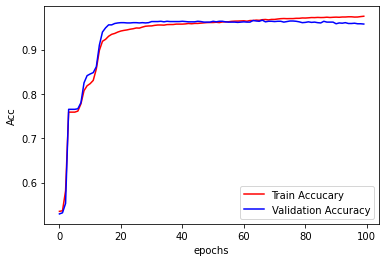

In [43]:
epoch = np.arange(len(train_accuracies))
plt.figure()
plt.plot(epoch, train_accuracies, 'r', epoch, val_accuracies, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('epochs'), plt.ylabel('Acc')

In [44]:
val_predictions = np.array(all_val_predictions_pr_epoch)
val_labels = np.array(all_val_targets_pr_epoch)
# val_predictions = val_predictions.reshape(val_predictions.shape[0],val_predictions.shape[1])
# val_labels = val_labels.reshape(val_labels.shape[0],val_labels.shape[1])

100
EPOCH: 66 Recall: 0.9828042328042328 accuracy: 0.9663760896637609 f1-score: 0.9649350649350649


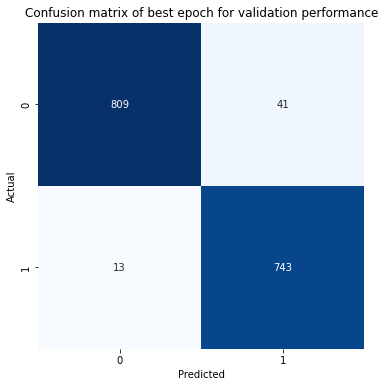

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,recall_score
best_epoch_model = np.argmax(val_accuracies)

print(len(val_predictions))

# for epoch in range(len(val_predictions)):
fig = plt.figure(figsize=(10,6))
accuracy = accuracy_score(val_labels[best_epoch_model],val_predictions[best_epoch_model])
recall = recall_score(val_labels[best_epoch_model],val_predictions[best_epoch_model])
f1 = f1_score(val_labels[best_epoch_model],val_predictions[best_epoch_model])

print(f"EPOCH: {best_epoch_model} Recall: {recall} accuracy: {accuracy} f1-score: {f1}")
plt.title("Confusion matrix of best epoch for validation performance")
conf_mat = confusion_matrix(val_labels[best_epoch_model],val_predictions[best_epoch_model])
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [2]:
def calculate_identity(query,database):
    if len(query) == len(database):
        return np.sum([1 for i in range(len(query)) if query[i] == database[i]])/len(query)
    
    elif len(query) > len(database):
        max_score = 0
        diff_len = len(query) - len(database)
        for i in range(diff_len + 1):
            query_shortened = query[i:i+len(database)]
            score = np.sum([1 for i in range(len(query_shortened)) if query_shortened[i] == database[i]])/len(query_shortened)
            if score > max_score:
                max_score = score

        return max_score
    
    elif len(query) < len(database):
        max_score = 0
        diff_len = len(database) - len(query)
        for i in range(diff_len + 1):
            database_shortened = database[i:i+len(query)]
            score = np.sum([1 for i in range(len(query)) if query[i] == database_shortened[i]])/len(database_shortened)
            if score > max_score:
                max_score = score

        return max_score
        
identity = [[calculate_identity(pep1,pep2) for pep1 in training_df["peptide"]] for pep2 in validation_df["peptide"]]
peptides = [[(pep1,pep2) for pep1 in training_df["peptide"]] for pep2 in validation_df["peptide"]]

NameError: name 'validation_df' is not defined

In [ ]:
identity = np.array(identity)
peptides = np.array(peptides)
max_identity = np.max(identity)
max_index = np.argmax(identity)

In [ ]:
max_identity

0.9

In [ ]:
max_row_index,max_column_index = np.where(identity == np.amax(identity))

In [ ]:
peptides[max_row_index[0],max_column_index[0]]

array(['FLPSDFFPSV', 'FLPPDFFPSV'], dtype='<U10')

In [ ]:

calculate_identity("FLPSDFFPSV","FLPPDFFPSV")

0.9

In [ ]:
peptides[467,1275]

array(['FLPSDFFPSV', 'FLPPDFFPSV'], dtype='<U10')

In [ ]:
8/9

0.8888888888888888